Scissor R包github在 https://github.com/sunduanchen/Scissor.

In [49]:
#安装
#devtools::install_github('sunduanchen/Scissor')

In [16]:
celltype <- "Macrophages"  ###修改细胞类型的名称

### Step1. R包加载

In [17]:
library(Seurat)
library(preprocessCore)
# library(scAB)
library(Scissor)
library(qs)
library(patchwork)

### Step2. 加载示例数据

如上所述，该算法需要三种类型的数据输入:

（1）单细胞RNA-seq数据是Seurat对象，

（2）Bulk RNA-seq表达矩阵，

（3）表型数据可以是一个有两列的矩阵，时间和状态，也可以是一个向量。

这里采用scAB包的示例数据进行演示：

In [18]:
bulk_df <- read.table("../1_bulk_data/Bulk_data.txt", header = TRUE, sep = "\t", stringsAsFactors = FALSE)
Phenotype_df <- read.table("../1_bulk_data/Phenotype.txt",row.names = 1, header = TRUE, sep = "\t", stringsAsFactors = FALSE)

### ————————之选bulk数据中的一部分——————

In [19]:
bulk_df <- bulk_df[, grepl("GSE193876", colnames(bulk_df)) | colnames(bulk_df) == "GeneSymbol"]
Phenotype_df <- Phenotype_df[grepl("GSE193876", rownames(Phenotype_df)), ]

### ————————之选bulk数据中的一部分——————

In [20]:
# 假设 bulk_df 已经读取
rownames(bulk_df) <- bulk_df$GeneSymbol   # 将 GeneSymbol 列设为行名
bulk_df$GeneSymbol <- NULL                # 删除 GeneSymbol 列

In [21]:
#样本名称需保持一致
table(colnames(bulk_df) == row.names(Phenotype_df))


TRUE 
   8 

### Step3. 处理单细胞数据

示例的单细胞数据sc_dataset是Seurat对象，可以看到并没有进行过降维聚类等处理。

作者提供了一个run_seurat函数，进行常规处理，run_seurat本质上就是把标准化、高变基因特征选择、归一化、PCA、降维聚类等基本流程打包为一个函数，最后用预先注释好的信息进行可视化：

In [22]:
sc_dataset = qread(paste0("/home/guoliming/Brown/ALI_CRL/ALI/",celltype,"/Outdata/Sub_annotion.qs"))

In [23]:
# Idents(sc_dataset) <- sc_dataset@meta.data$RNA_snn_res.0.1

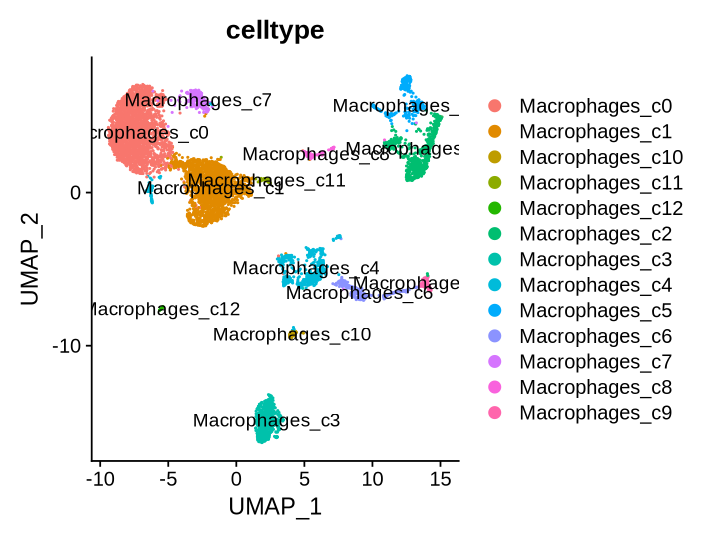

In [24]:
UMAP_celltype <- DimPlot(sc_dataset, reduction ="umap",
                         group.by="celltype",label = T)  ## 用RNA_snn_res.0.1进行sessors
                        # label = T)
options(repr.plot.width = 6, repr.plot.height = 4.5)
UMAP_celltype

In [25]:
levels(sc_dataset)

[1] "Macrophages_c4"  "Macrophages_c0"  "Macrophages_c1"  "Macrophages_c3" 
 [5] "Macrophages_c6"  "Macrophages_c11" "Macrophages_c7"  "Macrophages_c10"
 [9] "Macrophages_c8"  "Macrophages_c12" "Macrophages_c2"  "Macrophages_c5" 
[13] "Macrophages_c9"

### Step4. 运行Scissor

与scAB一样，在获取到了单细胞表达矩阵、Bulk RNA-seq表达矩阵及其临床信息之后，运行Scissor：

In [26]:
Scissor <- function (bulk_dataset, sc_dataset, phenotype, tag = NULL, alpha = NULL, 
                     cutoff = 0.2, family = c("gaussian", "binomial", "cox"), 
                     Save_file = "Scissor_inputs.RData", Load_file = NULL) 
{
  library(Seurat)
  library(Matrix)
  library(preprocessCore)
  if (is.null(Load_file)) {
    common <- intersect(rownames(bulk_dataset), rownames(sc_dataset))
    if (length(common) == 0) {
      stop("There is no common genes between the given single-cell and bulk samples.")
    }
    if (class(sc_dataset) == "Seurat") {
      sc_exprs <- as.matrix(sc_dataset@assays$RNA@data)
      network <- as.matrix(sc_dataset@graphs$RNA_snn)
    }
    else {
      sc_exprs <- as.matrix(sc_dataset)
      Seurat_tmp <- CreateSeuratObject(sc_dataset)
      Seurat_tmp <- FindVariableFeatures(Seurat_tmp, selection.method = "vst", 
                                         verbose = F)
      Seurat_tmp <- ScaleData(Seurat_tmp, verbose = F)
      Seurat_tmp <- RunPCA(Seurat_tmp, features = VariableFeatures(Seurat_tmp), 
                           verbose = F)
      Seurat_tmp <- FindNeighbors(Seurat_tmp, dims = 1:10, 
                                  verbose = F)
      network <- as.matrix(Seurat_tmp@graphs$RNA_snn)
    }
    diag(network) <- 0
    network[which(network != 0)] <- 1
    dataset0 <- cbind(bulk_dataset[common, ], sc_exprs[common, 
    ])
    dataset1 <- normalize.quantiles(as.matrix(dataset0))
    rownames(dataset1) <- rownames(dataset0)
    colnames(dataset1) <- colnames(dataset0)
    Expression_bulk <- dataset1[, 1:ncol(bulk_dataset)]
    Expression_cell <- dataset1[, (ncol(bulk_dataset) + 
                                     1):ncol(dataset1)]
    X <- cor(Expression_bulk, Expression_cell)
    quality_check <- quantile(X)
    print("|**************************************************|")
    print("Performing quality-check for the correlations")
    print("The five-number summary of correlations:")
    print(quality_check)
    print("|**************************************************|")
    if (quality_check[3] < 0.01) {
      warning("The median correlation between the single-cell and bulk samples is relatively low.")
    }
    if (family == "binomial") {
      Y <- as.numeric(phenotype)
      z <- table(Y)
      if (length(z) != length(tag)) {
        stop("The length differs between tags and phenotypes. Please check Scissor inputs and selected regression type.")
      }
      else {
        print(sprintf("Current phenotype contains %d %s and %d %s samples.", 
                      z[1], tag[1], z[2], tag[2]))
        print("Perform logistic regression on the given phenotypes:")
      }
    }
    if (family == "gaussian") {
      Y <- as.numeric(phenotype)
      z <- table(Y)
      if (length(z) != length(tag)) {
        stop("The length differs between tags and phenotypes. Please check Scissor inputs and selected regression type.")
      }
      else {
        tmp <- paste(z, tag)
        print(paste0("Current phenotype contains ", 
                     paste(tmp[1:(length(z) - 1)], collapse = ", "), 
                     ", and ", tmp[length(z)], " samples."))
        print("Perform linear regression on the given phenotypes:")
      }
    }
    if (family == "cox") {
      Y <- as.matrix(phenotype)
      if (ncol(Y) != 2) {
        stop("The size of survival data is wrong. Please check Scissor inputs and selected regression type.")
      }
      else {
        print("Perform cox regression on the given clinical outcomes:")
      }
    }
    save(X, Y, network, Expression_bulk, Expression_cell, 
         file = Save_file)
  }
  else {
    load(Load_file)
  }
  if (is.null(alpha)) {
    alpha <- c(0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 
               0.6, 0.7, 0.8, 0.9)
  }
  for (i in 1:length(alpha)) {
    set.seed(123)
    fit0 <- APML1(X, Y, family = family, penalty = "Net", 
                  alpha = alpha[i], Omega = network, nlambda = 100, 
                  nfolds = min(10, nrow(X)))
    fit1 <- APML1(X, Y, family = family, penalty = "Net", 
                  alpha = alpha[i], Omega = network, lambda = fit0$lambda.min)
    if (family == "binomial") {
      Coefs <- as.numeric(fit1$Beta[2:(ncol(X) + 1)])
    }
    else {
      Coefs <- as.numeric(fit1$Beta)
    }
    Cell1 <- colnames(X)[which(Coefs > 0)]
    Cell2 <- colnames(X)[which(Coefs < 0)]
    percentage <- (length(Cell1) + length(Cell2))/ncol(X)
    print(sprintf("alpha = %s", alpha[i]))
    print(sprintf("Scissor identified %d Scissor+ cells and %d Scissor- cells.", 
                  length(Cell1), length(Cell2)))
    print(sprintf("The percentage of selected cell is: %s%%", 
                  formatC(percentage * 100, format = "f", digits = 3)))
    if (percentage < cutoff) {
      break
    }
    cat("\n")
  }
  print("|**************************************************|")
  return(list(para = list(alpha = alpha[i], lambda = fit0$lambda.min, 
                          family = family), Coefs = Coefs, Scissor_pos = Cell1, 
              Scissor_neg = Cell2))
}

再次运行：

In [27]:
infos1 <- Scissor(bulk_df, sc_dataset, Phenotype_df, alpha = 0.05, 
                  family = "cox", Save_file = paste0(celltype,".RData"))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


[1] "|**************************************************|"
[1] "Performing quality-check for the correlations"
[1] "The five-number summary of correlations:"
        0%        25%        50%        75%       100% 
0.01384457 0.16736075 0.18579676 0.20059090 0.88778368 
[1] "|**************************************************|"
[1] "Perform cox regression on the given clinical outcomes:"
[1] "alpha = 0.05"
[1] "Scissor identified 4197 Scissor+ cells and 0 Scissor- cells."
[1] "The percentage of selected cell is: 57.978%"

[1] "|**************************************************|"


In [28]:
# pdf(paste0("Bulk1_DimPlot_", celltype, ".pdf"), height = 8,width = 20) #单位是英寸

# Scissor_select <- rep(0, ncol(sc_dataset))
# names(Scissor_select) <- colnames(sc_dataset)
# Scissor_select[infos1$Scissor_pos] <- "Scissor+"
# Scissor_select[infos1$Scissor_neg] <- "Scissor-"
# sc_dataset <- AddMetaData(sc_dataset, metadata = Scissor_select, col.name = "scissor")
# UMAP_scissor <- DimPlot(sc_dataset, reduction = 'umap', 
#         group.by = 'scissor',
#         cols = c('grey','royalblue','indianred1'), 
#         pt.size = 0.001, order = c("Scissor+","Scissor-"))

# options(repr.plot.width = 20, repr.plot.height = 8)
# patchwork::wrap_plots(plots = list(UMAP_celltype,UMAP_scissor), ncol = 2)

# dev.off()

In [29]:
pdf(paste0("Bulk1_DimPlot_", celltype, ".pdf"), height = 8, width = 20) #单位是英寸

# 创建 Scissor 标记
Scissor_select <- rep("Neutral", ncol(sc_dataset))  # 先统一设为 Neutral
names(Scissor_select) <- colnames(sc_dataset)
Scissor_select[infos1$Scissor_pos] <- "Scissor+"
Scissor_select[infos1$Scissor_neg] <- "Scissor-"

# 添加到 Seurat 对象
sc_dataset <- AddMetaData(sc_dataset, metadata = Scissor_select, col.name = "scissor")

# 强制设置 factor 顺序，确保颜色对应
sc_dataset$scissor <- factor(sc_dataset$scissor, levels = c("Neutral", "Scissor+", "Scissor-"))

# 绘制 UMAP
UMAP_scissor <- DimPlot(sc_dataset, reduction = 'umap', 
                        group.by = 'scissor',
                        cols = c('grey','royalblue','indianred1'), 
                        pt.size = 0.001)

# 并排显示
options(repr.plot.width = 20, repr.plot.height = 8)
patchwork::wrap_plots(plots = list(UMAP_celltype, UMAP_scissor), ncol = 2)

dev.off()


agg_record_1717190400 
                    2

In [30]:
library(gplots)
pdf(paste0("Bulk1_Balloonplot_", celltype, ".pdf"),height = 10,width = 18) #单位是英寸
balloonplot(table(sc_dataset$scissor,sc_dataset$celltype))
dev.off()

agg_record_1952113593 
                    2

In [63]:
sss

ERROR: Error: object 'sss' not found


In [ ]:
names(infos1)

[1] "para"        "Coefs"       "Scissor_pos" "Scissor_neg"

In [ ]:
length(infos1$Scissor_pos)

[1] 644

In [ ]:
infos1$Scissor_pos[1:4]

[1] "GSM8504081_ACAAAGACAGCTGGTC-1" "GSM8504081_CATTTCAAGACGCCCT-1"
[3] "GSM8504081_GGTGTCGAGGCCTGAA-1" "GSM8504081_TAGTGCAAGACGCCCT-1"

In [ ]:
length(infos1$Scissor_neg)

[1] 125

运行大概三五分钟，在本地文件夹下即可生成结果Rdata，检查结果可见共识别429个Scissor+细胞（即与表型呈正相关的细胞）和1001个Scissor阴性细胞（即与表型呈负相关的细胞）。这里要强调一下Scissor R包的运行速度是真的快。而scAB运行这个8000个细胞的示例数据，需要花费好几个小时，效率上相差甚远。

### Step5. 可视化结果

In [ ]:
pdf(paste0("DimPlot_", celltype, ".pdf"), height = 8,width = 20) #单位是英寸

Scissor_select <- rep(0, ncol(sc_dataset))
names(Scissor_select) <- colnames(sc_dataset)
Scissor_select[infos1$Scissor_pos] <- "Scissor+"
Scissor_select[infos1$Scissor_neg] <- "Scissor-"
sc_dataset <- AddMetaData(sc_dataset, metadata = Scissor_select, col.name = "scissor")
UMAP_scissor <- DimPlot(sc_dataset, reduction = 'umap', 
        group.by = 'scissor',
        cols = c('grey','royalblue','indianred1'), 
        pt.size = 0.001, order = c("Scissor+","Scissor-"))

options(repr.plot.width = 20, repr.plot.height = 8)
patchwork::wrap_plots(plots = list(UMAP_celltype,UMAP_scissor), ncol = 2)

dev.off()

agg_record_1110062951 
                    2

检查结果可知Scissor+ 细胞主要为肿瘤细胞，Scissor阴性细胞主要为T细胞和CAFs：

In [ ]:
table(sc_dataset$scissor,sc_dataset$celltype)

          
           Neutrophils_c0 Neutrophils_c1 Neutrophils_c2 Neutrophils_c3
  0                  1494           2141            104            179
  Scissor+           2922              2            811            196
          
           Neutrophils_c4 Neutrophils_c5 Neutrophils_c6
  0                   189             22             39
  Scissor+              0             98             18

In [ ]:
library(gplots)
pdf(paste0("Balloonplot_", celltype, ".pdf"),height = 10,width = 18) #单位是英寸
balloonplot(table(sc_dataset$scissor,sc_dataset$celltype))
dev.off()

agg_record_654713737 
                   2

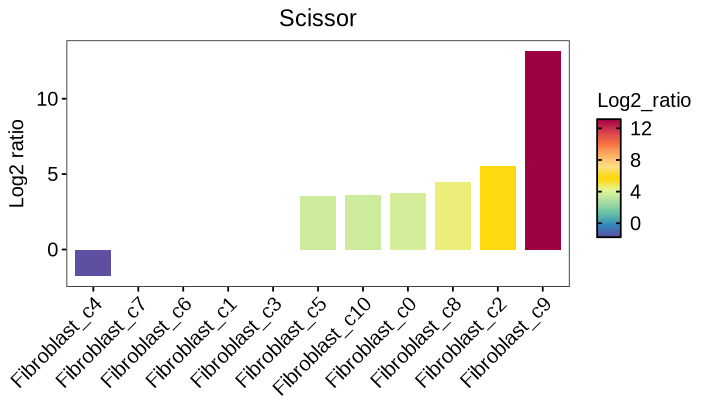

In [ ]:
source("../custom_seurat_functions.R")
options(repr.plot.width = 6, repr.plot.height = 3.5)
p3 = scissor_barplot(seurat.data = sc_dataset,
                celltype = "celltype",
                scissor_name = "scissor",
                pseudo_count = 0.01,
                width = 0.8,
                text.size = 12,
                text.angle = 45,
                text.hjust = 1,
                legend.position = "right",
                kepp_zero = TRUE, legend.key.size = 0.5,
                color_fill = 1,
                color_low = 'royalblue',color_high = 'indianred1',
                x.lab = NULL, y.lab = "Log2 ratio", title = "Scissor");p3


In [ ]:
pdf(paste0("UMAP_scissor_", celltype, ".pdf"),height = 10,width = 8) #单位是英寸

# options(repr.plot.width = 6, repr.plot.height = 8)
wrap_plots(UMAP_scissor, p3, ncol = 1, heights = c(3,1.5))
dev.off()


agg_record_1283858229 
                    2

In [ ]:
## 保存结果
qsave(sc_dataset, file = paste0(celltype,"_Scissor.qs"))

### Step6. 对比scAB的结果

加载上Step1.scAB的结果：

In [ ]:
scAB.res = read_rds("./Outdata/Step1.scAB.res.rds")

ERROR: Error in read_rds("./Outdata/Step1.scAB.res.rds"): could not find function "read_rds"


In [ ]:
table(row.names(sc_dataset@meta.data) == row.names(scAB.res@meta.data))

In [ ]:
sc_dataset$scAB = scAB.res$scAB_select

可视化：

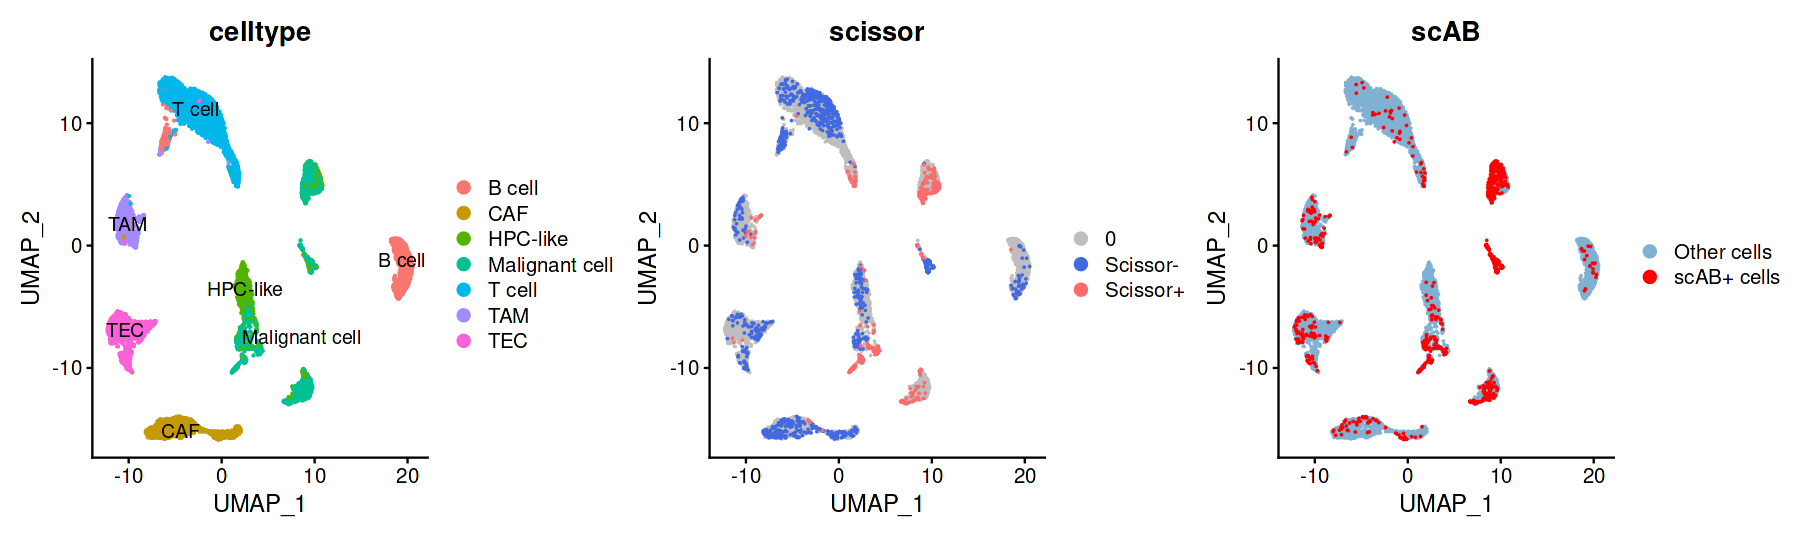

In [ ]:
UMAP_scAB <- DimPlot(sc_dataset,group.by="scAB",
                     cols=c("#80b1d3","red"),
                     pt.size=0.001,
                     order=c("scAB+ cells","Other cells"))

options(repr.plot.width = 15, repr.plot.height = 4.5)
patchwork::wrap_plots(plots = list(UMAP_celltype,UMAP_scissor,UMAP_scAB), ncol = 3)

比较交集：

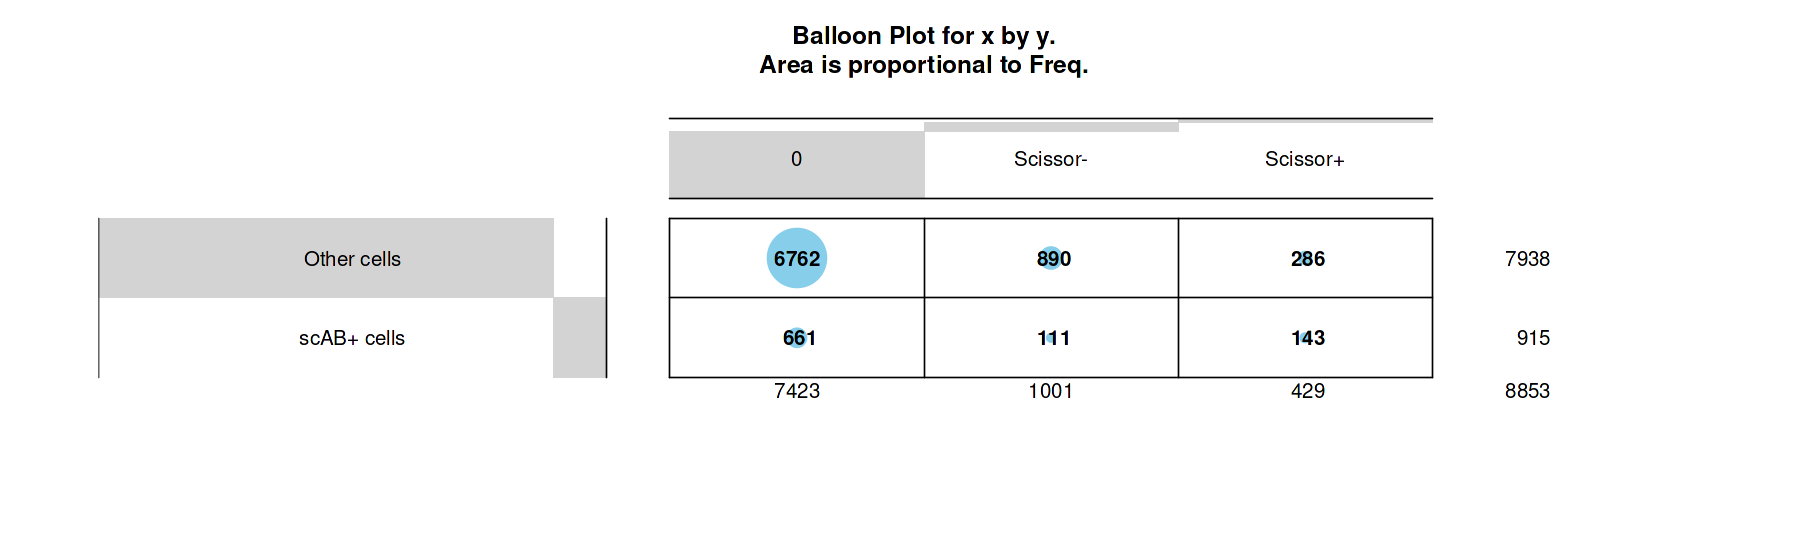

In [ ]:
balloonplot(table(sc_dataset$scissor,sc_dataset$scAB))

只有143个细胞是scAB+ Scissor+细胞。个人感觉结果相差还是有点大的。

总结来说：

（1）scAB运行较慢（8853个细胞需2小时左右），但是似乎会得到更多的表型相关阳性细胞（915/8853 vs. 429/8853），另外scAB可以整合scATAC-seq数据；

（2）而Scissor运行很快（8853个细胞需5分钟左右），但是似乎会得到更少的表型相关阳性细胞，另外Scissor还提供了表型相关阴性细胞。

### Step7. 复现一篇Cancer cell文章的可视化


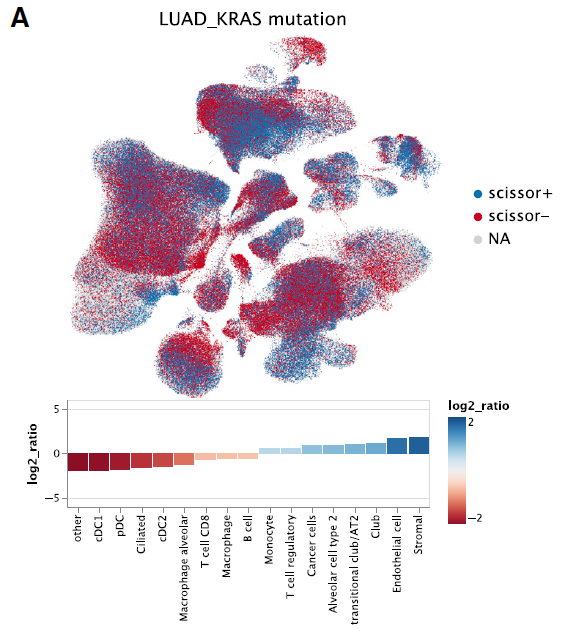

In [ ]:
source("../CellChat/Rawdata/custom_seurat_functions.R")

aplot v0.2.8 For help: https://github.com/YuLab-SMU/aplot/issues

If you use aplot in published research, please cite the paper:

Shuangbin Xu, Qianwen Wang, Shaodi Wen, Junrui Li, Nan He, Ming Li,
Thomas Hackl, Rui Wang, Dongqiang Zeng, Shixiang Wang, Shensuo Li,
Chunhui Gao, Lang Zhou, Shaoguo Tao, Zijing Xie, Lin Deng, and
Guangchuang Yu. aplot: Simplifying the creation of complex graphs to
visualize associations across diverse data types. The Innovation. 2025,
6(9):100958. doi: 10.1016/j.xinn.2025.100958

Export the citation to BibTex by citation('aplot')

This message can be suppressed by:
suppressPackageStartupMessages(library(aplot))


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats

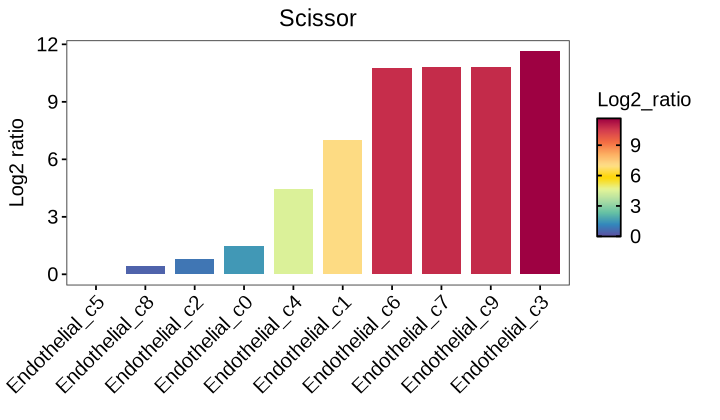

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 3.5)
p3 = scissor_barplot(seurat.data = sc_dataset,
                celltype = "celltype",
                scissor_name = "scissor",
                pseudo_count = 0.01,
                width = 0.8,
                text.size = 12,
                text.angle = 45,
                text.hjust = 1,
                legend.position = "right",
                kepp_zero = TRUE, legend.key.size = 0.5,
                color_fill = 1,
                color_low = 'royalblue',color_high = 'indianred1',
                x.lab = NULL, y.lab = "Log2 ratio", title = "Scissor");p3

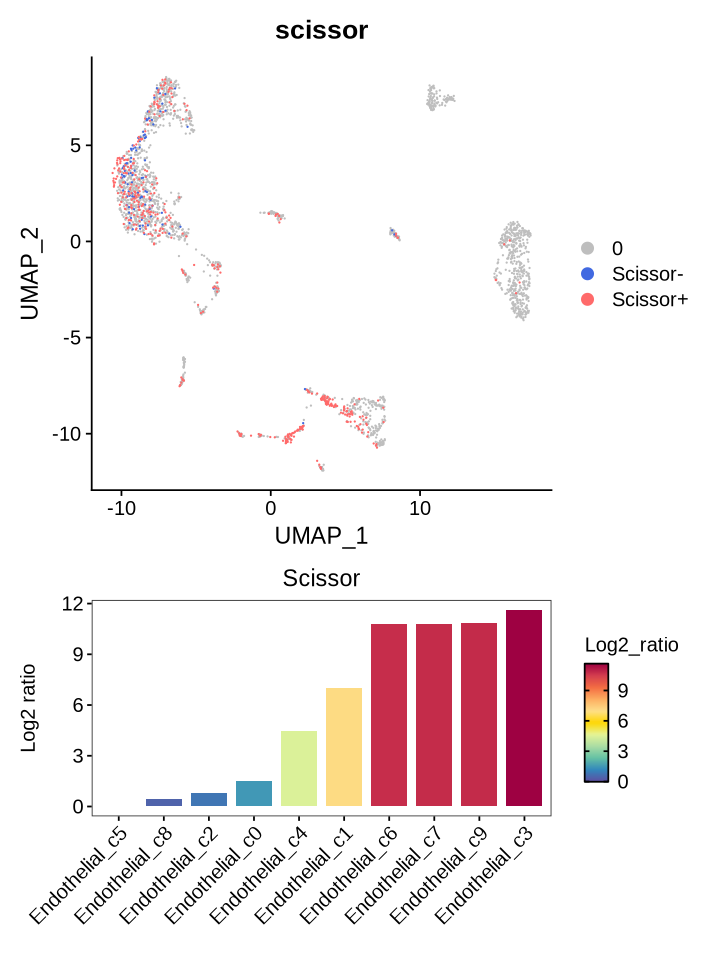

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 8)
wrap_plots(UMAP_scissor, p3, ncol = 1, heights = c(3,1.5))

In [ ]:
## 保存结果
qsave(sc_dataset, file = "./Outdata/Step2.Scissor_res.qs")

In [ ]:
### End